# DDPLKO Moduł 9 - praca domowa - Self-Supervised Learning

To dziewiąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wykonanie treningu SSL z wykorzystaniem jednej z metod, wybierz framework i metodę dowolnie
- [ ] dla zbioru danych STL10:
  - [ ] Trening SSL na unlabelled, 100k zdjęć
  - [ ] Trening od zera na zbiorze train, 5k zdjęć
  - [ ] Trening transfer learning modelu z SSL na zbiorze train, 5k zdjęć
- [ ] Udostępnij wykres z porównaniem wyników validation accuracy na Discordzie `#klasyfikacja-wyniki`


# STL10

Ten zbiór wygodnie wczytasz w TensorFlow jak i w PyTorchu, linki poniżej:

- Strona zbioru: https://cs.stanford.edu/~acoates/stl10/
- PyTorch Torchvision dataset: https://pytorch.org/vision/stable/datasets.html#stl10
- TensorFlow dataset:https://www.tensorflow.org/datasets/catalog/stl10

![STL10](https://cs.stanford.edu/~acoates/stl10/images.png)


W przypadku problemów z wielkością tego zbioru:
- możesz pracować na rozdzielczości np. 32x32px
- możesz ograniczyć wielkość zbioru unlabelled (ale lepiej zmniejsz rozdzielczość)

Extra - dodatkowo możesz:
- przeprowadzić eksperyment z SSL dla różnej wielkości modeli (np. R18 vs R101 czy EffNetB0 vs EffNetB4 itp.)

In [ ]:
from collections import defaultdict

import lightly
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from sklearn.metrics import accuracy_score
from torchvision import datasets
from torchvision.datasets import STL10

# STL10 Dataset

In [2]:
num_workers = 20
batch_size = 128
max_epochs = 50
input_size = 32
num_ftrs = 512
num_classes = 10
gpus = 1 if torch.cuda.is_available() else 0

In [3]:
collate_fn = lightly.data.SimCLRCollateFunction(input_size=input_size,
                                                gaussian_blur=0.)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'])
])

res = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((input_size, input_size))])
# lightly datasets
base_train = STL10(root='data',
                   download=True,
                   split='unlabeled',
                   transform=res)
dataset_train_simclr = lightly.data.LightlyDataset.from_torch_dataset(
    base_train)

base_test = STL10(root='data', download=True, split='test', transform=res)
dataset_test_simclr = lightly.data.LightlyDataset.from_torch_dataset(base_test)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dataloader_train_simclr = torch.utils.data.DataLoader(dataset_train_simclr,
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      collate_fn=collate_fn,
                                                      drop_last=True,
                                                      num_workers=num_workers)

dataloader_test_simclr = torch.utils.data.DataLoader(dataset_test_simclr,
                                                     batch_size=batch_size,
                                                     shuffle=False,
                                                     collate_fn=collate_fn,
                                                     drop_last=False,
                                                     num_workers=num_workers)


In [5]:
# datasets
dataset_train = STL10(root='data',
                      download=True,
                      split='train',
                      transform=transforms)
dataset_test = STL10(root='data',
                     download=True,
                     split='test',
                     transform=transforms)

# dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               drop_last=True,
                                               num_workers=num_workers)

dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=False,
                                              num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
class SimCLR_ResNet(pl.LightningModule):

    def __init__(self):
        super().__init__()

        resnet = torchvision.models.resnet18(pretrained=False)
        backbone = nn.Sequential(*list(resnet.children())[:-1])

        # create a SimCLR based on ResNet
        self.resnet_simclr = lightly.models.SimCLR(backbone,
                                                   num_ftrs=num_ftrs,
                                                   out_dim=num_ftrs)

        # create our loss
        self.criterion = lightly.loss.NTXentLoss()

        self.loss_train = []
        self.loss_val = []

    def forward(self, x):
        self.resnet_simclr(x)

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        y0, y1 = self.resnet_simclr(x0, x1)
        loss = self.criterion(y0, y1)
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        mean_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.loss_train.append(mean_loss.detach().cpu().item())

    def validation_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        y0, y1 = self.resnet_simclr(x0, x1)
        loss = self.criterion(y0, y1)
        return {"loss": loss}

    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.loss_val.append(mean_loss.detach().cpu().item())

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.resnet_simclr.parameters())
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs)
        return [optim], [scheduler]

# Trening SSL na unlabelled, 100k zdjęć

In [ ]:
model_simclr = SimCLR_ResNet()
trainer = pl.Trainer(max_epochs=max_epochs, gpus=gpus, num_sanity_val_steps=0)

trainer.fit(model_simclr, dataloader_train_simclr, dataloader_test_simclr)

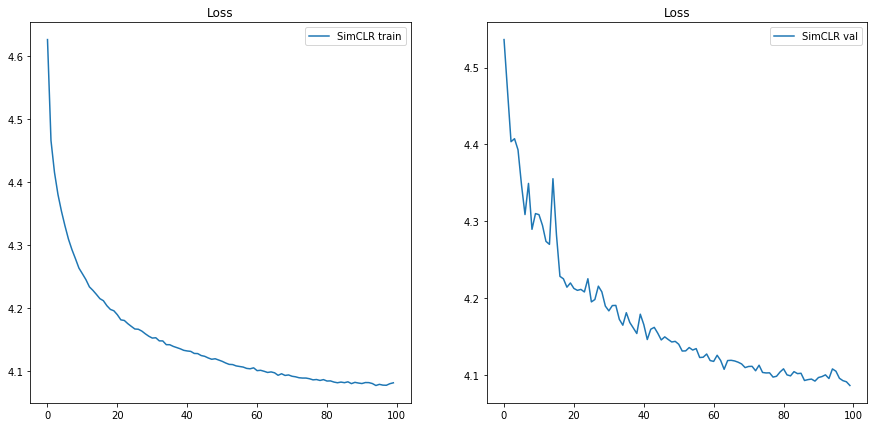

In [8]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.plot(np.asarray(model_simclr.loss_train), label='SimCLR train')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(np.asarray(model_simclr.loss_val), label='SimCLR val')
plt.title('Loss')
plt.legend()

In [13]:
class Classifier(pl.LightningModule):

    def __init__(self, model, transfer_learning=False):
        super().__init__()

        self.model = model
        self.transfer_learning = transfer_learning

        # freeze the layers of simclr resnet
        if transfer_learning:
            for p in self.model.parameters():  # reset requires_grad
                p.requires_grad = False

            # we create a linear layer for our downstream classification model
            self.fc = nn.Linear(num_ftrs, num_classes)

        self.history = defaultdict(lambda: [])

    def forward(self, x):
        if self.transfer_learning:
            with torch.no_grad():
                y_hat = self.model(x).squeeze()
            return self.fc(y_hat)
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)
        acc = accuracy_score(
            y.detach().cpu().numpy(),
            torch.max(y_hat, dim=1).indices.detach().cpu().numpy())
        return {'loss': loss, 'accuracy': acc}

    def training_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        self.history['loss_train'].append(mean_loss.detach().cpu().item())
        self.history['accuracy_train'].append(mean_acc.item())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)
        acc = accuracy_score(
            y.detach().cpu().numpy(),
            torch.max(y_hat, dim=1).indices.detach().cpu().numpy())
        return {'loss': loss, 'accuracy': acc}

    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        self.history['loss_val'].append(mean_loss.detach().cpu().item())
        self.history['accuracy_val'].append(mean_acc.item())

    def configure_optimizers(self):
        if self.transfer_learning:
            optim = torch.optim.Adam(self.fc.parameters())
        else:
            optim = torch.optim.Adam(self.model.parameters())

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs)
        return [optim], [scheduler]

# Trening od zera na zbiorze train, 5k zdjęć

In [ ]:
resnet = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
model_classifier = Classifier(resnet)

trainer = pl.Trainer(max_epochs=max_epochs, gpus=gpus, num_sanity_val_steps=0)

trainer.fit(model_classifier, dataloader_train, dataloader_test)

In [15]:
def plot_results(histories, titles):
    if type(histories) != list:
        histories = [histories]
        titles = [titles]
    plt.figure(figsize=(15, 15))

    plt.subplot(221)
    for history, title in zip(histories, titles):
        plt.plot(history['loss_train'], label=title + ' train')
    plt.title('Loss')
    plt.legend()

    plt.subplot(223)
    for history, title in zip(histories, titles):
        plt.plot(history['loss_val'], label=title + ' val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(222)
    for history, title in zip(histories, titles):
        plt.plot(history['accuracy_train'], label=title + ' train')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(224)
    for history, title in zip(histories, titles):
        plt.plot(history['accuracy_val'], label=title + ' val')
    plt.title('Accuracy')
    plt.legend()

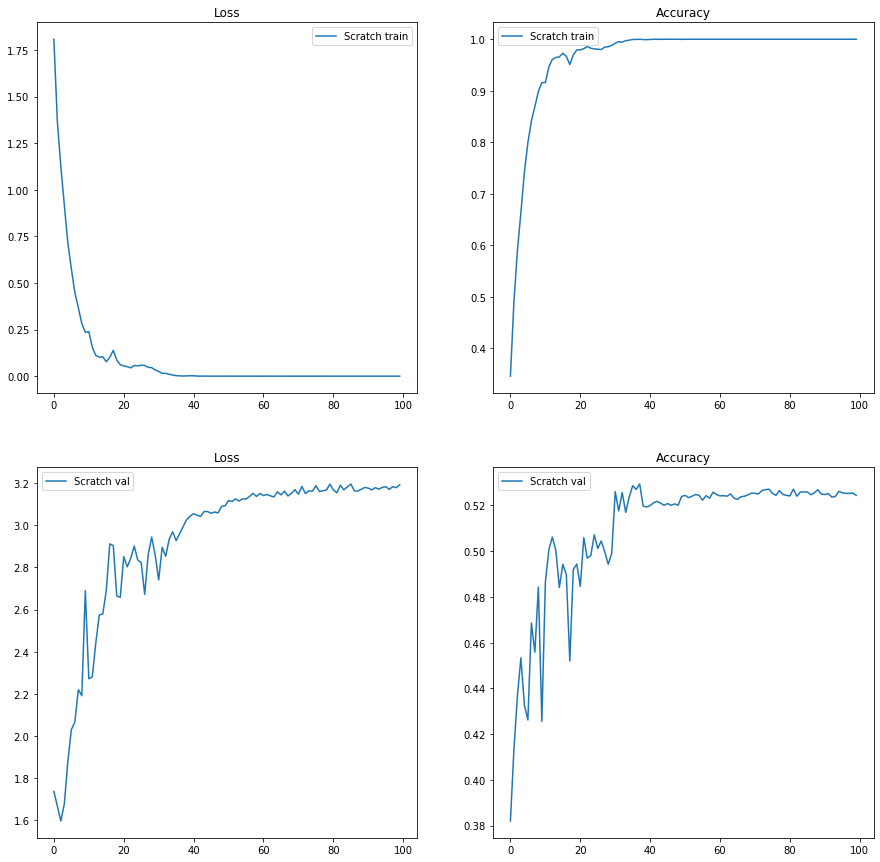

In [16]:
plot_results(model_classifier.history, 'Scratch')

# Trening transfer learning modelu z SSL na zbiorze train, 5k zdjęć

In [ ]:
model_simclr.eval()
model_classifier_tl = Classifier(model_simclr.resnet_simclr.backbone,
                                 transfer_learning=True)

trainer = pl.Trainer(max_epochs=max_epochs, gpus=gpus, num_sanity_val_steps=0)

trainer.fit(model_classifier_tl, dataloader_train, dataloader_test)

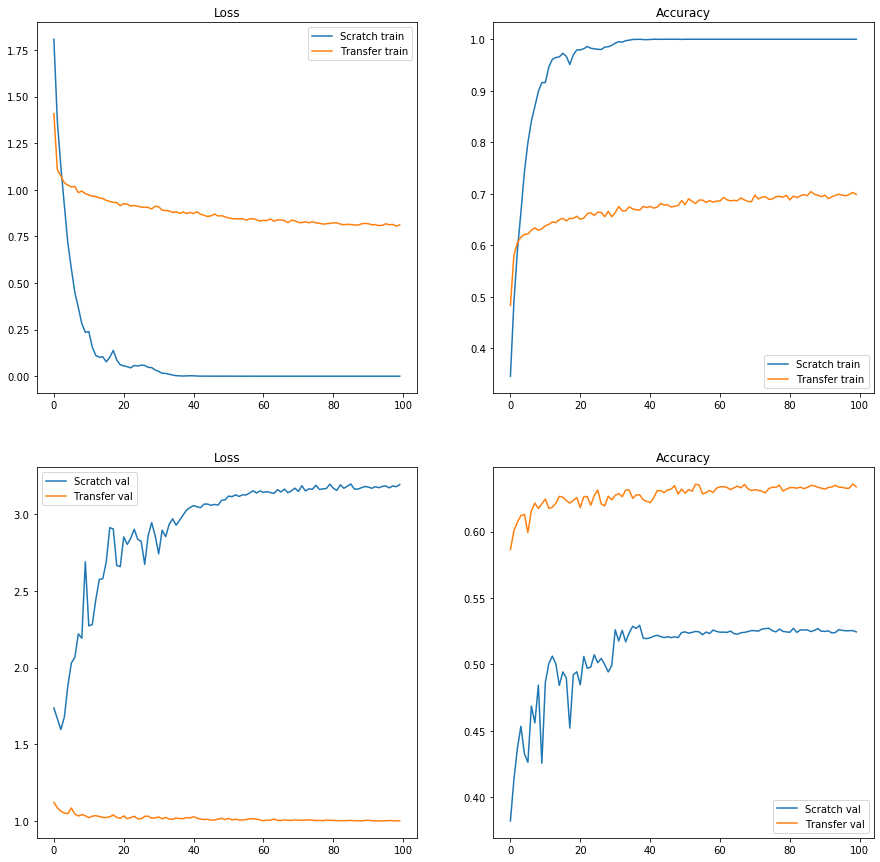

In [18]:
plot_results([model_classifier.history, model_classifier_tl.history],
             ['Scratch', 'Transfer'])


# Summary / extra

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.